<a href="https://colab.research.google.com/github/hasmeu/colab/blob/main/stateunion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.2 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset
from collections import Counter

from datetime import datetime, timedelta

import nltk
from nltk.draw.dispersion import dispersion_plot

In [3]:
# Load the dataset
dataset = load_dataset("jsulz/state-of-the-union-addresses")

# Extract the necessary columns
dates = [item["date"] for item in dataset["train"]]
potus=[item["potus"] for item in dataset["train"]]
texts = [item["lemmatized"] for item in dataset["train"]]

# Combine dates, potus texts, then sort by dates
sorted_data = sorted(zip(dates, potus, texts), key=lambda x: x[0])
sorted_dates, sorted_potus,sorted_texts = zip(*sorted_data)




README.md:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

sotu.parquet:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/245 [00:00<?, ? examples/s]

In [ ]:
sorted_dates[0:8]

(Timestamp('1790-01-08 00:00:00'),
 Timestamp('1790-12-08 00:00:00'),
 Timestamp('1791-10-25 00:00:00'),
 Timestamp('1792-11-06 00:00:00'),
 Timestamp('1793-12-03 00:00:00'),
 Timestamp('1794-11-19 00:00:00'),
 Timestamp('1795-12-08 00:00:00'),
 Timestamp('1796-12-07 00:00:00'))

In [4]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming sorted_dates, sorted_potus, sorted_texts are defined

start_date = pd.Timestamp('1790-01-08')
block_size = timedelta(days=365 * 5)  # 5 years
current_date = start_date
blocks = []

current_block_texts = []
current_block_year = None

for date, potus, text in zip(sorted_dates, sorted_potus, sorted_texts):
    date = pd.Timestamp(date)
    if date >= current_date + block_size:
        # Start a new block
        if current_block_texts:
            blocks.append({
                "year": current_block_year,
                "text": current_block_texts
            })
        current_block_texts = []
        current_date += block_size
        current_block_year = date.year

    current_block_texts.extend(text)

# Append the last block
if current_block_texts:
    blocks.append({
        "year": current_block_year,
        "text": current_block_texts
    })

In [5]:
max_length = 0

for block in blocks:
    text_length = len(block["text"])
    if text_length > max_length:
        max_length = text_length

print(f"The length of the longest 'text' field is: {max_length}")

# Pad the blocks with "OOV" tokens
for block in blocks:
    padding_length = max_length - len(block["text"])
    block["text"].extend(["OOV"] * padding_length)

The length of the longest 'text' field is: 52162


In [6]:
years = [block["year"] for block in blocks]
all_texts = [block["text"] for block in blocks]
focus_words = ["liberty", "poverty", "freedom", "duty", "war", "peace"]
# Customize with the words you want to focus on

<Figure size 2000x1000 with 0 Axes>

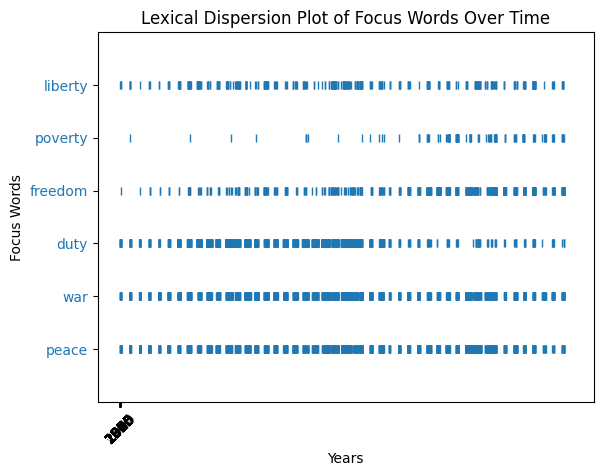

In [15]:
import nltk
from nltk.draw.dispersion import dispersion_plot

# Combine all texts into a single list for dispersion_plot
all_words = [word for sublist in all_texts for word in sublist]

plt.figure(figsize=(20, 10))  # Adjust figure size as needed
dispersion_plot(all_words, focus_words)
plt.xticks(range(len(years)), years, rotation=45)  # Set x-axis ticks to years
plt.xlabel("Years")
plt.ylabel("Focus Words")
plt.title("Lexical Dispersion Plot of Focus Words Over Time")
plt.show()

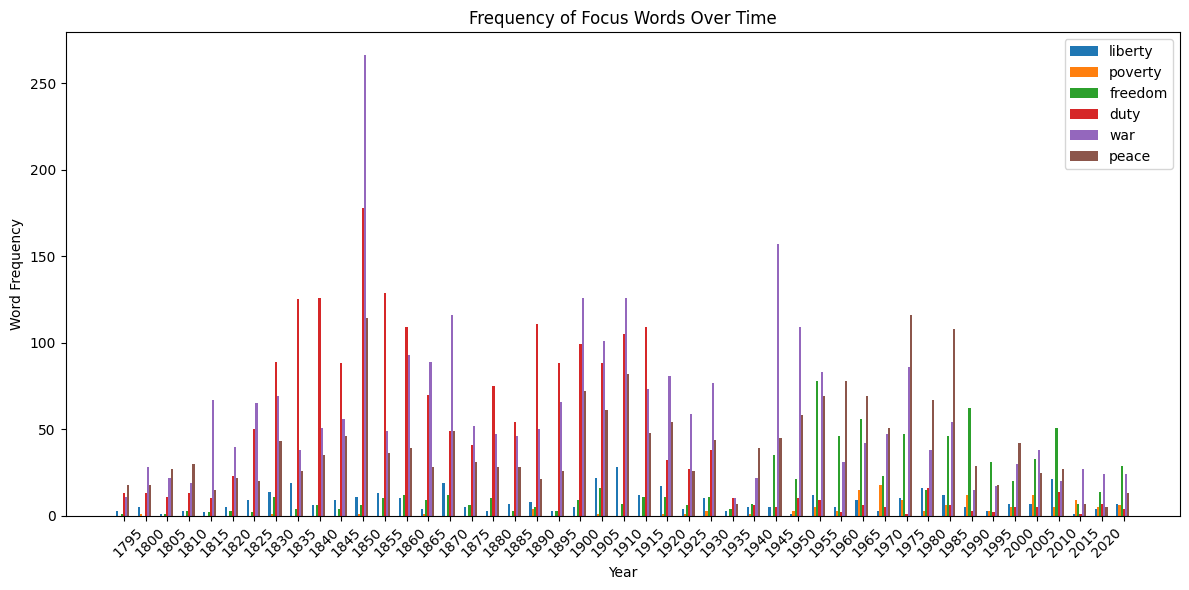

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

years = [block["year"] for block in blocks]
focus_words = ["liberty", "poverty", "freedom", "duty", "war", "peace"]

word_frequencies_by_year = []

for block in blocks:
    year = block["year"]
    text = block["text"]
    word_counts = Counter(text)  # Count word frequencies in the block

    # Extract frequencies of focus words for this year
    focus_word_frequencies = {word: word_counts.get(word, 0) for word in focus_words}

    word_frequencies_by_year.append((year, focus_word_frequencies))

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.1  # Adjust bar width for better spacing
x_positions = np.arange(len(years))

for i, word in enumerate(focus_words):
    frequencies = [year_data[1][word] for year_data in word_frequencies_by_year]
    ax.bar(x_positions + i * bar_width, frequencies, width=bar_width, label=word)

ax.set_xlabel("Year")
ax.set_ylabel("Word Frequency")
ax.set_title("Frequency of Focus Words Over Time")
ax.set_xticks(x_positions + (len(focus_words) / 2) * bar_width)  # Center x-ticks
ax.set_xticklabels(years, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()